In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet
pd.set_option('display.max_columns',60)

# Step 1: Define Helper Functions

In [2]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Step 2: Load Dataset

In [3]:
train_df = pd.read_csv('train.csv',index_col = 0)
#test_df = pd.read_csv('test.csv',index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Step 3: EDA

## Seasonal Trend 

In [4]:
# Time Series of Trip Count
daily_trip = train_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')

### Time Series Plot of Daily Trip Counts, Average Trip Duration(s) and Average Distance (mile)

Text(0, 0.5, 'Avg Distance(mile)')

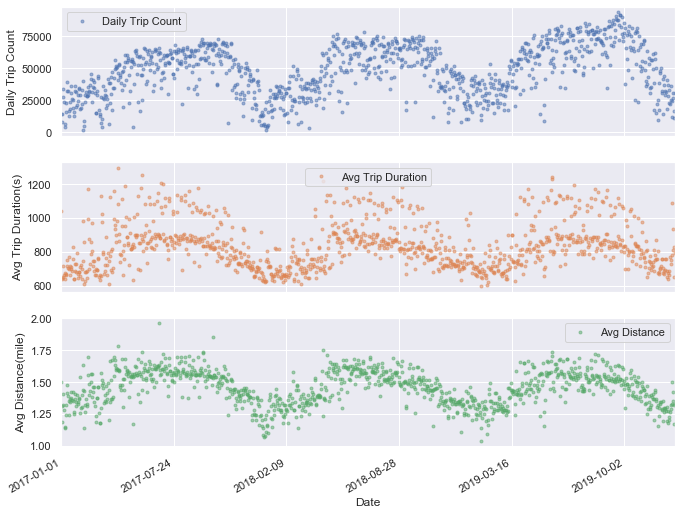

In [5]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Monthly Aaverage Trip Counts

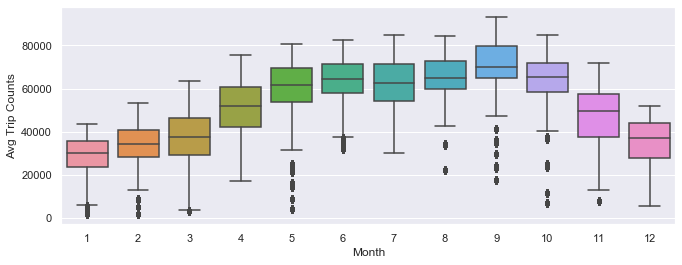

In [6]:
month_trip = train_df[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip)

### Monthly Average Trip Duration(s)

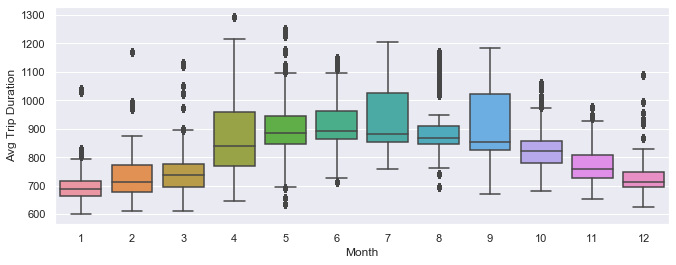

In [7]:
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip)

### Monthly Average Bike Distance(mile)

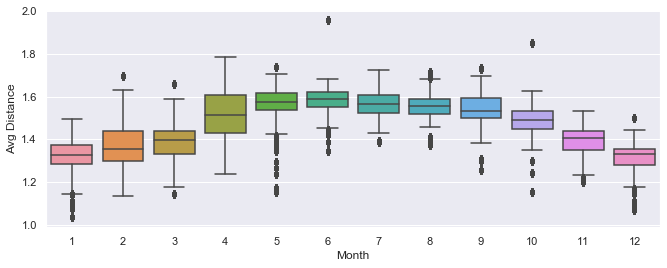

In [8]:
sns.boxplot(x="Month", y="Avg Distance", data=month_trip)

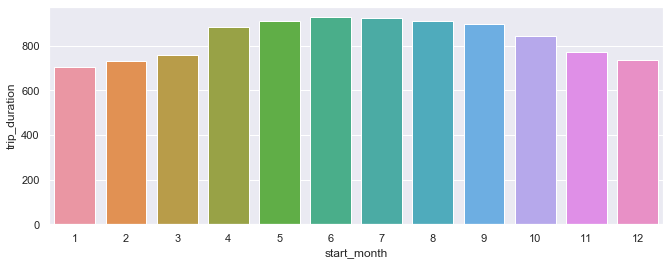

In [9]:
a = train_df.groupby('start_month').mean()[['trip_duration']].reset_index()
sns.barplot(x = a.start_month, y = a.trip_duration)

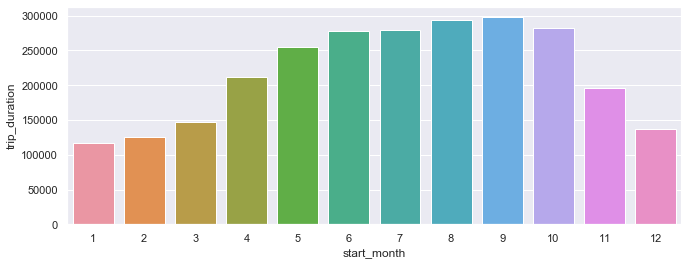

In [10]:
b = train_df.groupby('start_month').count()[['trip_duration']].reset_index()
sns.barplot(x = b.start_month, y = b.trip_duration)

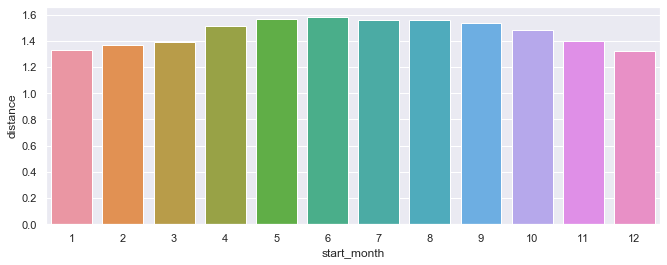

In [11]:
c = train_df.groupby('start_month').mean()[['distance']].reset_index()
sns.barplot(x = c.start_month, y = c.distance)

## Weather Impact

### Temperature's impact on ride counts

[Text(0.5, 1.0, 'Trip Count per Day v.s. Average Temperature')]

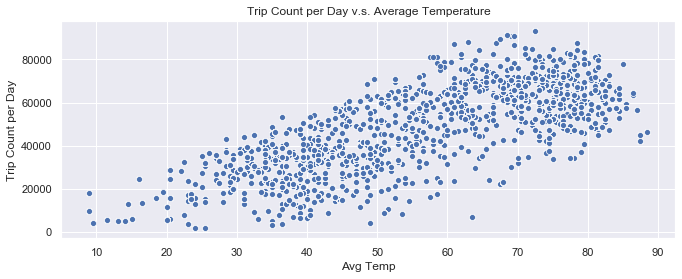

In [12]:
TEMP = train_df[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
TEMP.columns = ['Avg Temp','Avg Trip Duration(s)','Trip Count per Day','Avg Distance(mile)']
sns.scatterplot(x='Avg Temp',y='Trip Count per Day',data = TEMP).set(title = 'Trip Count per Day v.s. Average Temperature')


### Unusual Weather Conditions' impact on Ride Counts

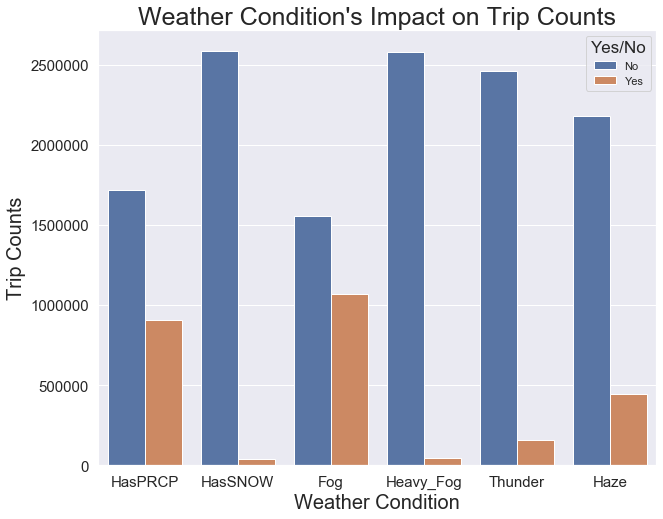

In [13]:
extreme_weather = train_df[['HasPRCP','HasSNOW','Fog', 'Heavy_Fog', 'Thunder', 'Haze']].apply(pd.value_counts)
extreme_weather= extreme_weather.unstack().reset_index()
extreme_weather.columns=['Weather Condition','Yes/No','Trip Counts']
extreme_weather['Yes/No']=['Yes' if x==1 else 'No' for x in extreme_weather['Yes/No']]
plt.figure(figsize=(10,8))
plt.rcParams["axes.labelsize"] = 20
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Weather Condition's Impact on Trip Counts", fontdict = {'fontsize' : 25})
sns.barplot(x='Weather Condition', y ='Trip Counts', hue ='Yes/No', data = extreme_weather)

## Number of stations in different years

In [14]:
train_df.loc[train_df.start_year == 2017].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2018].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2019].start_station_ID.nunique() 
train_df.start_station_ID.nunique()  
station_2017 = list(train_df.loc[train_df.start_year == 2017].start_station_ID.unique())
station_2018 = list(train_df.loc[train_df.start_year == 2018].start_station_ID.unique())
station_2019 = list(train_df.loc[train_df.start_year == 2019].start_station_ID.unique())
remove2018 =[item for item in station_2017 if item not in station_2018]
new2018 =[item for item in station_2018 if item not in station_2017]
remove2019 = [item for item in station_2018 if item not in station_2019]
new2019 =[item for item in station_2019 if item not in station_2018]
print('Number of stations removed in 2018: %.f' %len(remove2018))
print('Number of stations removed in 2019: %.f' %len(remove2019))
print('Number of stations added in 2018: %.f' %len(new2018))
print('Number of stations added in 2019: %.f' %len(new2019))

Number of stations removed in 2018: 40
Number of stations removed in 2019: 47
Number of stations added in 2018: 58
Number of stations added in 2019: 165


- 2017 has 799 unique stations, 2018 has 812 unique stations, and 2019 has 926 unique stations.
- Total unique stations for all three years are 1011 stations 

## Weekdays and Weekends

Text(0, 0.5, 'Avg Distance(mile)')

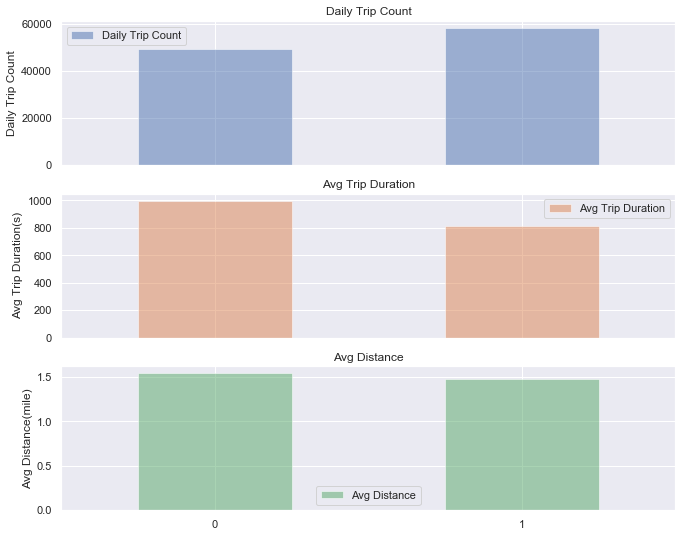

In [15]:
Weekday = train_df[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()

sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True,rot = 0)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

## Rush Hours

In [16]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,265888
18,252466
8,217080
16,193695
19,175537
9,171875


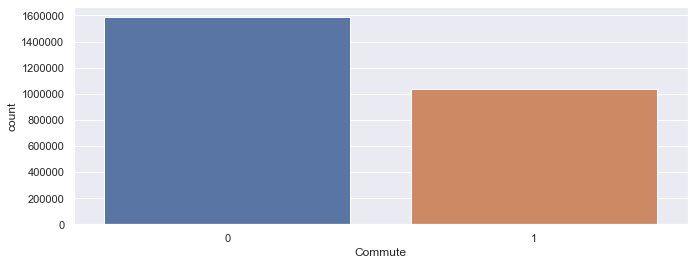

In [17]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df['Commute'] = np.where(((train_df['Isweekday']==1) &
                                        (train_df['start_hour'].isin(rushhours))),1,0)
sns.countplot(x = 'Commute',data = train_df)

## Top 50 Stations on Weekdays and Weekend

In [18]:
top50_weekdays = train_df.loc[train_df['Isweekday']==1].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

top50_weekends = train_df.loc[train_df['Isweekday']==0].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

In [19]:
# Merge Dataset and export csv for Tableau Visualization
top50_weekdays['Isweekday'] ='Weekday'
top50_weekends['Isweekday'] ='Weekend'
top50_all_days = pd.concat([top50_weekdays,top50_weekends],axis = 0).reset_index()
top50_all_days.columns=['Station Name','Trip Count','Latitude','Longitude','Isweekday']
top50_all_days.to_csv('Top50_All_Days.csv')

In [20]:
top50_all_days.head()

,Station Name,Trip Count,Latitude,Longitude,Isweekday
0,Pershing Square North,121.037812,40.751873,-73.977706,Weekday
1,E 47 St & Park Ave,78.529457,40.755103,-73.974987,Weekday
2,Broadway & E 22 St,75.262766,40.740343,-73.989551,Weekday
3,8 Ave & W 31 St,68.957936,40.750585,-73.994685,Weekday
4,West St & Chambers St,66.260889,40.717548,-74.013221,Weekday


In [21]:
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

C:\Users\zhang\Anaconda3\lib\site-packages\IPython\core\display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Top 50 start stations on weekdays during rush hours

In [22]:
top50_weekdays_rush_start = train_df.loc[train_df['Commute']==1].groupby(['start_station_name']).\
agg({'start_station_checkout_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_start['Isstart'] ='Start Station'
top50_weekdays_rush_start = top50_weekdays_rush_start.reset_index()
top50_weekdays_rush_start.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [23]:
# Top 50 end stations on weekdays during rush hours
top50_weekdays_rush_end = train_df.loc[train_df['Commute']==1].groupby(['end_station_name']).\
agg({'end_station_checkout_counts':'mean','end_station_latitude':lambda x: x.iloc[0], 'end_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'end_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_end['Isstart'] = 'End Station'
top50_weekdays_rush_end.reset_index(inplace=True)
top50_weekdays_rush_end.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [24]:
# Merge Dataset and export csv for Tableau Visualization
top50_rushhours = pd.concat([top50_weekdays_rush_start,top50_weekdays_rush_end],axis = 0)
top50_rushhours.to_csv('Top50_Rushhours.csv')

In [25]:
top50_rushhours.head()

,Station Name,Trip Count,Latitude,Longitude,Isstart
0,Pershing Square North,82.431308,40.751873,-73.977706,Start Station
1,E 47 St & Park Ave,67.851441,40.755103,-73.974987,Start Station
2,Broadway & E 22 St,64.167887,40.740343,-73.989551,Start Station
3,W 52 St & 6 Ave,57.485161,40.761330,-73.979820,Start Station
4,Penn Station Valet - Valet Scan,56.920000,40.751284,-73.996925,Start Station


In [26]:
# Top 50 start and end stations during commuting rush hours
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays_rush_start['Longitude'].values, 
         top50_weekdays_rush_start['Latitude'].values, 'bv',alpha = 0.5,markersize=8)
plt.plot(top50_weekdays_rush_end['Longitude'].values, 
         top50_weekdays_rush_end['Latitude'].values, 'ro',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

## Top 200 Dock Stations at All Times 

In [27]:
Top200_ID = list(train_df.groupby(['start_station_ID']).agg({'trip_duration':'count'}).\
sort_values(by='trip_duration',ascending=False).head(200).index)

In [28]:
Top200 = train_df.loc[train_df['start_station_ID'].isin(Top200_ID)]

In [29]:
selected_cols=['start_station_latitude','start_station_longitude', 'start_hour',\
              'start_year','start_month','start_dayofweek','start_station_checkout_counts',\
              'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze',\
               'TAVG','HasPRCP', 'HasSNOW', 'tot_docks', 'Percent_usage','Isweekday', 'Commute']  # should we remove year? 
Top200 = Top200.loc[:,selected_cols]

In [30]:
Top200.drop_duplicates(inplace=True)

In [31]:
X = Top200.drop('start_station_checkout_counts',axis = 1)
Y = Top200.start_station_checkout_counts

## Correlation Heat Map

In [32]:
# from string import ascii_letters
# import numpy as np
# import pandas as pd
# import seaborn as sns 

# sns.set(style="white")
# corr =train_df.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
# corr.to_csv('Correlation_Matrix.csv')

In [34]:
# corr.dtypes

## K-mean Clustering 
- Create clusters on dock stations based on location and usage, what else could be useful? 

In [35]:
train_df.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID',
       'start_date', 'start_year', 'start_month', 'start_day', 'start_hour',
       'start_dayofweek', 'Isweekday', 'holidays', 'stop_date', 'stop_hour',
       'start_station_checkout_counts', 'start_station_checkin_counts',
       'start_station_total_counts', 'end_station_checkout_counts',
       'end_station_checkin_counts', 'end_station_total_counts', 'distance',
       'trip_per_day', 'daily_avg_trip_duration', 'daily_avg_distance',
       'trip_per_hour', 'hourly_avg_trip_duration', 'hourly_avg_distance',
       'trip_per_hour_eachday', 'hourly_avg_trip_duration_eachday',
       'hourly_avg_distance_eachday', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'T

In [36]:
station = train_df.groupby(['start_station_name']).agg({
                                                           'trip_duration':'count',
                                                            #'tot_docks':'median', #(remove this)
                                                            'Percent_usage':'mean',
                                                              'distance': 'mean'
                                                           })
station.reset_index(inplace=True)
# Try to remove longitude and latitude and see how it looks like 
#'start_station_longitude':lambda x:x.iloc[0],'start_station_latitude':lambda x:x.iloc[0]

In [37]:
station = station.dropna(how = 'any')
station= station.loc[station.Percent_usage<5]
station.shape

(961, 4)

In [38]:
station

,start_station_name,trip_duration,Percent_usage,distance
0,1 Ave & E 110 St,1331,0.259294,1.541327
1,1 Ave & E 16 St,10240,0.575854,1.243520
2,1 Ave & E 18 St,7645,0.433243,1.250915
3,1 Ave & E 30 St,6399,0.714460,1.465603
4,1 Ave & E 44 St,4742,0.373250,1.728074
...,...,...,...,...
1008,Wyckoff St & Nevins St,1,0.181818,0.783526
1009,Wythe Ave & Metropolitan Ave,5011,0.649992,1.454499
1010,Yankee Ferry Terminal,1386,0.904659,2.224067
1011,York St & Jay St,1675,0.642631,1.542120


In [39]:
scaler = StandardScaler()
scaler.fit(station.iloc[:,1:])
station_scaled = scaler.transform(station.iloc[:,1:])
kmeans = KMeans()

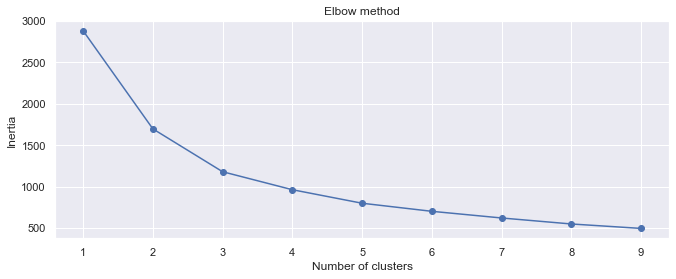

In [40]:
plot_inertia(kmeans, station_scaled, range(1, 10))

In [41]:
kmeans.set_params(n_clusters=4)
kmeans.fit(station_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [42]:
kmeans.cluster_centers_

array([[-0.59155774, -0.53409641,  1.81320714],
       [ 0.9011765 ,  0.75220005, -0.34281871],
       [ 2.49397591,  2.54519693, -0.11705647],
       [-0.48979526, -0.44901225, -0.3124283 ]])

In [43]:
#pd.concat([station,station_labels],axis=1)
station['cluster']= kmeans.labels_
station

,start_station_name,trip_duration,Percent_usage,distance,cluster
0,1 Ave & E 110 St,1331,0.259294,1.541327,3
1,1 Ave & E 16 St,10240,0.575854,1.243520,1
2,1 Ave & E 18 St,7645,0.433243,1.250915,1
3,1 Ave & E 30 St,6399,0.714460,1.465603,1
4,1 Ave & E 44 St,4742,0.373250,1.728074,1
...,...,...,...,...,...
1008,Wyckoff St & Nevins St,1,0.181818,0.783526,3
1009,Wythe Ave & Metropolitan Ave,5011,0.649992,1.454499,1
1010,Yankee Ferry Terminal,1386,0.904659,2.224067,0
1011,York St & Jay St,1675,0.642631,1.542120,1


In [44]:
station_geo = train_df.groupby('start_station_name')[['start_station_longitude','start_station_latitude']].apply(lambda x:x.iloc[0])
station_geo.reset_index(inplace=True)

In [45]:
cluster = station.merge(station_geo,how='left',on='start_station_name')
cluster

,start_station_name,trip_duration,Percent_usage,distance,cluster,start_station_longitude,start_station_latitude
0,1 Ave & E 110 St,1331,0.259294,1.541327,3,-73.938300,40.792327
1,1 Ave & E 16 St,10240,0.575854,1.243520,1,-73.981656,40.732219
2,1 Ave & E 18 St,7645,0.433243,1.250915,1,-73.980544,40.733812
3,1 Ave & E 30 St,6399,0.714460,1.465603,1,-73.975361,40.741444
4,1 Ave & E 44 St,4742,0.373250,1.728074,1,-73.969053,40.750020
...,...,...,...,...,...,...,...
956,Wyckoff St & Nevins St,1,0.181818,0.783526,3,-73.984275,40.683426
957,Wythe Ave & Metropolitan Ave,5011,0.649992,1.454499,1,-73.963198,40.716887
958,Yankee Ferry Terminal,1386,0.904659,2.224067,0,-74.016966,40.686931
959,York St & Jay St,1675,0.642631,1.542120,1,-73.986569,40.701485


In [46]:
cluster.to_csv('cluster.csv')

In [47]:
cluster.groupby('cluster').agg({'trip_duration':'mean','Percent_usage':'mean','distance':'mean'})

,trip_duration,Percent_usage,distance
cluster,,,
0,913.920290,0.209043,2.330399
1,5436.527027,0.587094,1.433302
2,10263.203390,1.114120,1.526902
3,1220.667897,0.233960,1.446707


## Supervised Machine Learning
### Predict hourly usage for top200 stations 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

In [49]:
X

,start_station_latitude,start_station_longitude,start_hour,start_year,start_month,start_dayofweek,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,Percent_usage,Isweekday,Commute
0,40.751873,-73.977706,18,2017,1,4,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,2.688525,1,1
2,40.722174,-73.983688,8,2017,1,3,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,58.0,0.344828,1,1
3,40.732233,-73.988900,20,2017,1,5,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,34.0,0.294118,1,0
4,40.755942,-74.002116,18,2017,1,3,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,56.0,0.196429,1,1
5,40.730473,-73.986724,6,2017,1,3,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,39.0,0.153846,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625354,40.773407,-73.977825,16,2019,12,2,6.93,0.13,0.0,0.0,58,39,1.0,0.0,0.0,0.0,0.0,0.0,48.5,1,0,43.0,0.186047,1,1
2625359,40.715348,-73.960241,17,2019,12,5,6.04,0.00,0.0,0.0,33,22,0.0,0.0,0.0,0.0,0.0,0.0,27.5,0,0,31.0,0.354839,1,1
2625360,40.726218,-73.983799,11,2019,12,1,4.47,1.57,0.0,0.0,55,42,1.0,0.0,0.0,0.0,0.0,0.0,48.5,1,0,31.0,0.258065,1,0
2625364,40.715595,-73.987030,10,2019,12,4,5.82,0.00,0.0,0.0,46,36,1.0,0.0,0.0,0.0,0.0,1.0,41.0,0,0,28.0,0.428571,1,0


In [50]:
lasso = Lasso(normalize=True,tol=0.01)
alphas = np.logspace(-8,-2,100)

alpha_coefs = []
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X, Y)
    alpha_coefs.append(lasso.coef_)
    
# the order of predictors to become zero coefficient
coefs_df = pd.DataFrame(alpha_coefs, index=alphas, columns = list(X.columns))

C:\Users\zhang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3619352.647873003, tolerance: 1610967.812207017
  positive)
C:\Users\zhang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3619363.5503614917, tolerance: 1610967.812207017
  positive)
C:\Users\zhang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3619376.0771030746, tolerance: 1610967.812207017
  positive)
C:\Users\zhang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

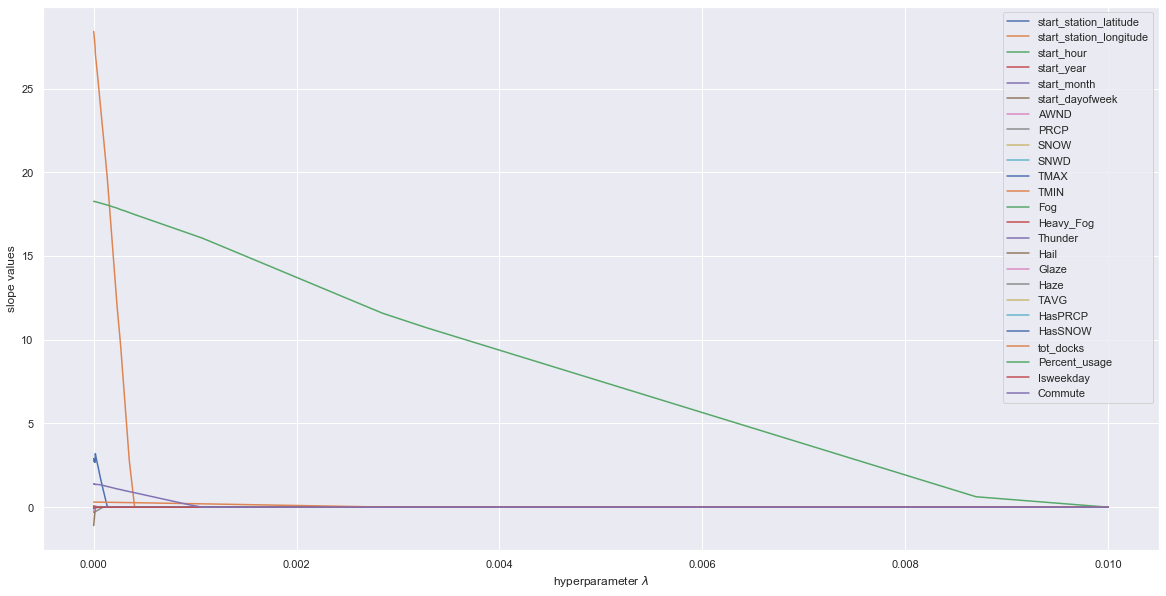

In [51]:
plt.figure(figsize=(20,10))
for name in coefs_df.columns:
    plt.plot(coefs_df.index, coefs_df[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)   

In [52]:
### find the alpha where coefficient becomes zero ###
alpha_zero = {}
for col in coefs_df.columns:
    for alpha in coefs_df.index:
        if coefs_df.loc[alpha, col] == 0:
            alpha_zero[col] = alpha
            break
alpha_zero = sorted(alpha_zero.items(), key=lambda x: x[1], reverse=True)
alpha_zero

[('Percent_usage', 0.01),
 ('tot_docks', 0.0032745491628777316),
 ('Commute', 0.0010722672220103231),
 ('start_station_longitude', 0.0004037017258596558),
 ('TMAX', 0.00030538555088334185),
 ('start_station_latitude', 0.0001519911082952933),
 ('PRCP', 0.0001),
 ('start_month', 7.56463327554629e-05),
 ('start_dayofweek', 7.56463327554629e-05),
 ('start_hour', 6.579332246575683e-05),
 ('start_year', 5.72236765935022e-05),
 ('HasPRCP', 3.274549162877732e-05),
 ('HasSNOW', 2.1544346900318867e-05),
 ('Hail', 1.8738174228603867e-05),
 ('SNWD', 1.629750834620647e-05),
 ('Glaze', 1.629750834620647e-05),
 ('Haze', 1.072267222010323e-05),
 ('AWND', 7.0548023107186455e-06),
 ('Thunder', 6.1359072734131755e-06),
 ('TMIN', 2.0092330025650458e-06),
 ('SNOW', 1.519911082952933e-06),
 ('Fog', 6.579332246575682e-07),
 ('Heavy_Fog', 4.3287612810830616e-07),
 ('Isweekday', 4.3287612810830616e-07),
 ('TAVG', 1.747528400007683e-08)]